# Classification   $ $

<hr>
<em> Solving the classification problem of EEG signals associted with a breaking event.<br>
First the signals are divided in sub intervales and we look differents statistics.<br>
The we input thee extract features from the series and use them with normal supervised learning.
</em> 
<hr>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from advisedlib.extraction.csv import CsvExtractor
from advisedlib.dataframe import SynchronousPandasDataFrame, AsynchronousPandasDataFrame, StaticPandasDataFrame
from advisedlib.feature_selection.ls import LS
from advisedlib.feature_extraction.tsfresh_feature_extractor import Tsfresh
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features, select_features

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_auc_score as AUC, accuracy_score as accuracy

In [2]:
path_to_data = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/Balanced_01'))
files = sorted([elt for elt in os.listdir(path_to_data) if elt[-4:] == '.npy'],
                   key=(lambda x: int(x.split('_')[2])))
np.random.RandomState(seed=0).shuffle(files)
eeg_channels_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 
 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 
 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P9', 'P7',
 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 
 'O1', 'Oz', 'O2']

In [3]:
# DO not run
df_eeg = pd.DataFrame([])
labels = []
time_names = ['t'+ str(x) for x in range(319 + 1)]
for num, file in enumerate(files): # create a pandas df with 
    label = {'event': 1.0, 'noevent': 0.0}[file.split('_')[-1].split('.')[0]]
    df_interval = pd.DataFrame(data = np.load(os.path.join(path_to_data,file)))
    df_interval.insert(0, "seq_id", num, True) 
    df_interval.insert(1, "event", label, True) 
    df_interval.insert(2, "param", eeg_channels_names, True) 
    df_interval.columns = ["seq_id", "event", "param"] + time_names
    
    df_eeg = df_eeg.append(df_interval)
    
    labels.append(label)
df_eeg.to_csv(r'df_eeg.csv', index = False)

In [7]:
df_eeg.shape

(27140, 323)

In [6]:
print(sync_df.shape)
#print(df_eeg.T.shape)
#print(sync_df.time_mesh)
len(sync_df.time_mesh)

(27140, 322)


320

In [7]:
params = sync_df.param.drop_duplicates().tolist()
print(params)
assert len(params) == len(eeg_channels_names)

['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P9', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


In [8]:
sync_df.check()

,seq_id,param,t0,t1,t2,t3,t4,t5,t6,t7,...,t310,t311,t312,t313,t314,t315,t316,t317,t318,t319
0,0,Fp1,3.260067,1.425563,1.731313,1.807751,-0.944005,-5.836016,-9.428586,-9.428586,...,-28.002940,-28.385128,-29.531693,-30.601821,-30.907571,-29.913882,-28.232253,-27.315001,-28.690879,-32.283449
1,0,Fp2,-11.504865,-10.010080,-9.511818,-10.807298,-11.704170,-9.711122,-5.027462,-0.742410,...,-25.854805,-20.573230,-15.490959,-13.198955,-13.398260,-13.996174,-14.295131,-15.192002,-17.185049,-19.477054
2,0,AF3,-1.064910,-1.064910,-1.463752,-4.255650,-8.882223,-12.711111,-13.109954,-10.238288,...,-26.431294,-22.283332,-20.448656,-21.884490,-25.394304,-28.186201,-28.425507,-27.388516,-27.787359,-30.898331
3,0,AF4,-15.698112,-15.280164,-13.942732,-13.691963,-14.862217,-15.029396,-11.602225,-4.998653,...,-35.174470,-27.818592,-22.468863,-22.719631,-27.985771,-34.004216,-36.762671,-36.344723,-36.010365,-37.765745
4,0,F7,4.643943,2.063975,0.265815,-2.705058,-7.317729,-11.304953,-11.539496,-7.864995,...,-11.930400,-14.041284,-19.592125,-25.768414,-29.990180,-31.006532,-28.426563,-22.953902,-17.246699,-13.884922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27135,459,PO4,6.839674,4.713774,-0.028618,-4.280417,-7.305736,-10.821647,-15.891101,-20.306431,...,49.357669,43.143500,38.237578,35.866382,35.212259,34.966963,34.394605,34.067543,35.130493,38.564639
27136,459,PO8,7.541322,5.111437,-0.529368,-5.475920,-8.079368,-10.248909,-13.806955,-16.931093,...,37.220634,30.017760,23.509139,18.996495,16.913736,16.826955,18.215461,20.471783,23.595921,27.761438
27137,459,O1,21.555931,15.862986,7.404896,0.492033,-3.249045,-5.607551,-8.860663,-12.927053,...,50.264642,41.481241,35.056345,33.348461,34.975017,36.845557,37.170868,37.414851,40.261324,46.198253
27138,459,Oz,17.658318,14.949861,8.301831,1.489651,-3.763114,-8.605506,-13.776197,-18.126143,...,50.159801,42.526877,37.602410,36.535442,37.602410,38.259006,37.520336,36.781666,38.176931,42.362728


In [9]:
context_df.event.value_counts()

0.0    230
1.0    230
Name: event, dtype: int64

## Feature extraction: tsfresh + selector
[Tsfresh](https://tsfresh.readthedocs.io) is a python library that is designed to extract automatically a lot of features from a timeseries. 

A wrapper for tsfresh extractor is embedded in advisedlib. It can be coupled with a feature selection step in order to reduce the number of generated features and to be able to handle them afterwards with an anomaly scorer.

### Conversion to asynchronous format
The tsfresh wrapper needs an asynchronous input, so we first convert the dataset to asynchronous format.
See the [cookbook](https://docs.cognitive.bocacc.io/advised-lib/notebooks/cookbook.html#Conversion-between-advised-formats) for an example.

In [10]:
async_df = sync_df.to_asynchronous()
display(async_df)

,seq_id,param,time,value
0,0,Fp1,2000-01-01 00:00:00.000,3.260067
1,0,Fp1,2000-01-01 00:00:00.005,1.425563
2,0,Fp1,2000-01-01 00:00:00.010,1.731313
3,0,Fp1,2000-01-01 00:00:00.015,1.807751
4,0,Fp1,2000-01-01 00:00:00.020,-0.944005
...,...,...,...,...
8684795,459,O2,2000-01-01 00:00:01.575,38.895641
8684796,459,O2,2000-01-01 00:00:01.580,39.714325
8684797,459,O2,2000-01-01 00:00:01.585,40.451139
8684798,459,O2,2000-01-01 00:00:01.590,42.088506


In [44]:
selector = LS(max_n_features_selected=10) # How many to select?
feature_extractor = Tsfresh(
    default_fc_parameters=EfficientFCParameters(), 
    selector=selector,
)

static_df, context_df = feature_extractor.fit_transform((async_df, context_df))

Feature Extraction: 100%|██████████| 20/20 [17:41<00:00, 53.08s/it]  


In [45]:
selector.selected_features_

['CP1__mean_change',
 'CP1__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
 'CP1__fft_coefficient__coeff_98__attr_"real"',
 'CP3__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
 'CP3__mean_change',
 'CP1__fft_coefficient__coeff_99__attr_"real"',
 'CP1__fft_coefficient__coeff_94__attr_"real"',
 'CP1__fft_coefficient__coeff_96__attr_"real"',
 'CP1__fft_coefficient__coeff_95__attr_"real"',
 'CP1__fft_coefficient__coeff_97__attr_"real"']

In [46]:
selector.features_score_.sort_values("laplacian_score")

,features_names,laplacian_score
6640,CP1__mean_change,0.161778
6061,"CP1__change_quantiles__f_agg_""mean""__isabs_Fal...",0.161778
6580,"CP1__fft_coefficient__coeff_98__attr_""real""",0.164670
7555,"CP3__change_quantiles__f_agg_""mean""__isabs_Fal...",0.164923
8134,CP3__mean_change,0.164923
...,...,...
38312,"PO7__fft_coefficient__coeff_0__attr_""imag""",1.000000
21638,FC5__symmetry_looking__r_0.15000000000000002,1.000000
21639,FC5__symmetry_looking__r_0.2,1.000000
20153,FC3__symmetry_looking__r_0.6000000000000001,1.000000


Text(0.5, 1.0, 'Features Laplacian scores')

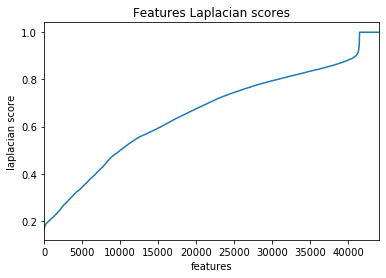

In [49]:
selector.features_score_["laplacian_score"].sort_values().reset_index(drop=True).plot()
plt.xlabel("features")
plt.ylabel("laplacian score")
plt.title("Features Laplacian scores")

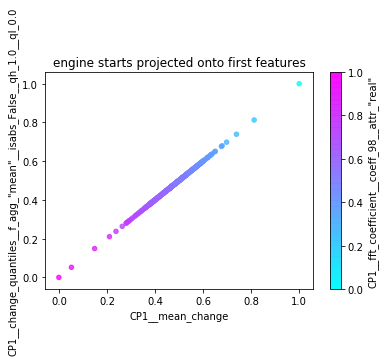

In [58]:
static_df.plot.scatter(
    x=selector.selected_features_[0],
    y=selector.selected_features_[1],
    c=selector.selected_features_[2],
    colormap="cool",  # choose a colormap suited to your colourblindness 
    sharex=False,
    alpha=0.8
)
plt.title("engine starts projected onto first features");

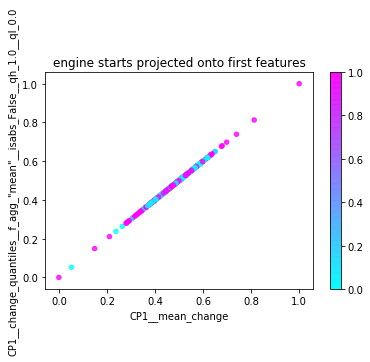

In [65]:
static_df.plot.scatter(
    x=selector.selected_features_[0],
    y=selector.selected_features_[1],
    c=labels,
    colormap="cool",  # choose a colormap suited to your colourblindness 
    sharex=False,
    alpha=0.8
)
plt.title("engine starts projected onto first features");

In [11]:
async_df

,seq_id,param,time,value
0,0,Fp1,2000-01-01 00:00:00.000,3.260067
1,0,Fp1,2000-01-01 00:00:00.005,1.425563
2,0,Fp1,2000-01-01 00:00:00.010,1.731313
3,0,Fp1,2000-01-01 00:00:00.015,1.807751
4,0,Fp1,2000-01-01 00:00:00.020,-0.944005
...,...,...,...,...
8684795,459,O2,2000-01-01 00:00:01.575,38.895641
8684796,459,O2,2000-01-01 00:00:01.580,39.714325
8684797,459,O2,2000-01-01 00:00:01.585,40.451139
8684798,459,O2,2000-01-01 00:00:01.590,42.088506


In [12]:
f = extract_features( async_df, column_id = "seq_id", column_sort = "time", column_kind='param', column_value="value" )

Feature Extraction: 100%|██████████| 20/20 [39:55<00:00, 119.79s/it] 


In [15]:
impute( f )
assert f.isnull().sum().sum() == 0

In [23]:
features_file = "df_eeg_features.csv"

In [24]:
f['y'] = labels
f.to_csv( features_file, index = None )

In [25]:
features = pd.read_csv( features_file )

In [33]:
validation_split_i = int(features.shape[0]/2)

In [34]:
train_x = features.iloc[:validation_split_i].drop( 'y', axis = 1 )
test_x = features.iloc[validation_split_i:].drop( 'y', axis = 1 )

train_y = features.iloc[:validation_split_i].y
test_y = features.iloc[validation_split_i:].y

In [37]:
train_features_selected = select_features( train_x, train_y, fdr_level = 0.05 )

In [86]:
print(train_features_selected.columns)

Index(['PO7__spkt_welch_density__coeff_2', 'P7__spkt_welch_density__coeff_2',
       'O1__spkt_welch_density__coeff_2', 'P9__spkt_welch_density__coeff_2',
       'P5__spkt_welch_density__coeff_2', 'PO3__spkt_welch_density__coeff_2',
       'P6__spkt_welch_density__coeff_2', 'PO4__spkt_welch_density__coeff_2',
       'Oz__spkt_welch_density__coeff_2',
       'PO3__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"',
       ...
       'CP1__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"rvalue"',
       'O2__ratio_beyond_r_sigma__r_0.5',
       'FC2__fft_coefficient__coeff_7__attr_"real"',
       'FCz__longest_strike_below_mean', 'PO3__spkt_welch_density__coeff_8',
       'AF3__fft_coefficient__coeff_8__attr_"abs"',
       'FCz__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"slope"',
       'P10__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
       'FT8__autocorrelation__lag_3',
       'FCz__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"intercept"'],


In [38]:
train = train_features_selected.copy()
train['y'] = train_y

test = test_x[ train_features_selected.columns ].copy()
test['y'] = test_y

In [39]:
train_file = "df_eeg_train.csv"
test_file = "df_eeg_test.csv"

In [40]:
train.to_csv( train_file, index = None )
test.to_csv( test_file, index = None )

In [41]:
train = pd.read_csv( train_file )
test = pd.read_csv( test_file )

x_train = train.drop( 'y', axis = 1 ).values
y_train = train.y.values

x_test = test.drop( 'y', axis = 1 ).values
y_test = test.y.values

In [96]:
classifiers = [
#LR( C = 10 ),
#LR( C = 1 ),
#LR( C = 0.1 ),
    
#make_pipeline( StandardScaler(), LR()),	
#make_pipeline( StandardScaler(), LR( C = 10 )),
make_pipeline( StandardScaler(), LR( C = 30 )),

#make_pipeline( MinMaxScaler(), LR()),
#make_pipeline( MinMaxScaler(), LR( C = 10 )),	
make_pipeline( MinMaxScaler(), LR( C = 30 )),

#LDA(),
RF( n_estimators = 100, min_samples_leaf = 5 )
]

In [97]:
for clf in classifiers:
    clf.fit( x_train, y_train )
    p = clf.predict_proba( x_test )[:,1]
    p_bin = clf.predict( x_test )
    
    auc = AUC( y_test, p )
    acc = accuracy( y_test, p_bin )
    print( "AUC: {:.2%}, accuracy: {:.2%} \n\n{}\n\n".format( auc, acc, clf ))


AUC: 92.49%, accuracy: 86.52% 

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=30, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


AUC: 92.02%, accuracy: 83.91% 

Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=30, class_weight=None, dual=False,
                                    fi

/Users/obando_c/anaconda3/envs/advisedlib-env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC: 89.95%, accuracy: 82.17% 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)




In [ ]:
# The NN does a better job in terms of accuracy 

In [ ]:
# What if I collapse all the electrodes into one cirtual one and then extract features in thet signal

In [2]:
import numpy as np

In [5]:
brr = np.load("/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/AllSubjects_events/VPgab.mat_segment_137_event.npy")

In [8]:
sum(sum(brr))

-583453.4829946416